### Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy import plotting
import subjects

### Some example good replays with sharp wave ripples

Note: speed_thresh is ignored when epochs is provided
[2427, 6347, 4319, 3236, 3120, 3482]


meta NOT subset; don't know how to subset; dropped


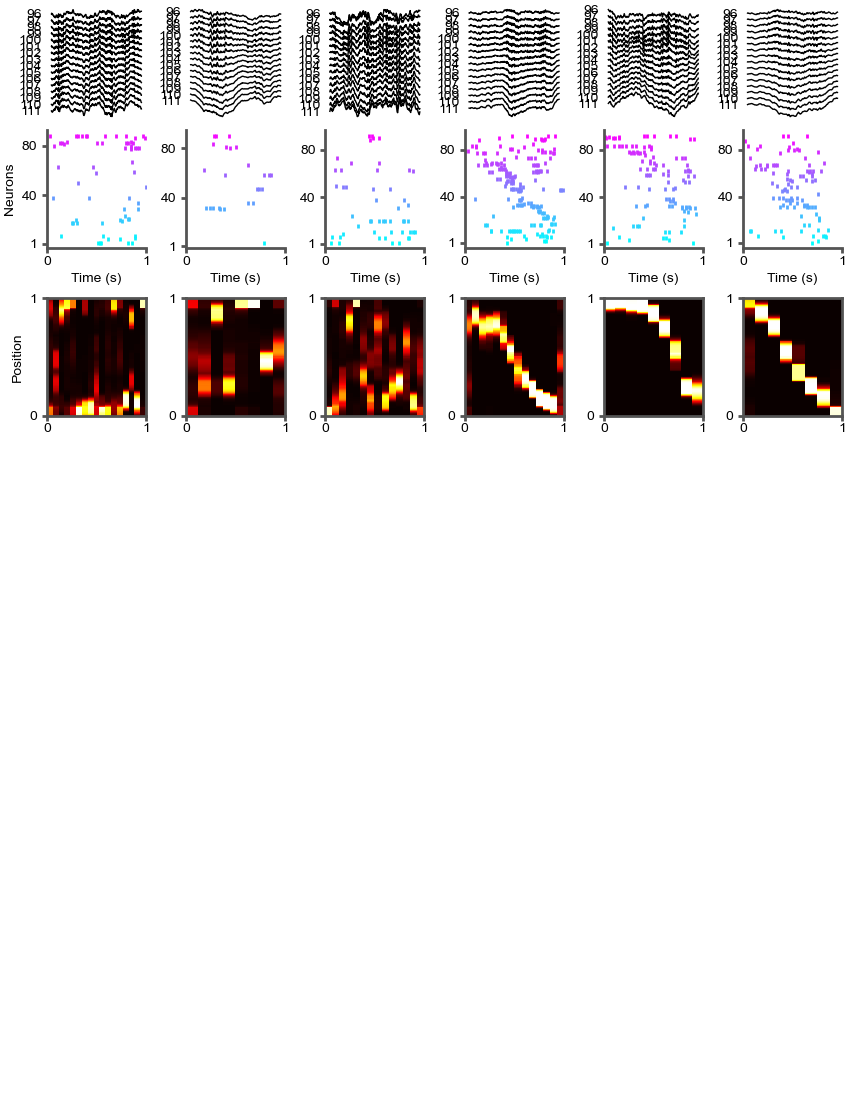

In [74]:
from neuropy.analyses.placefields import Pf1D

sess = subjects.nsd.ratUday2[0]
maze = sess.paradigm["maze"].flatten()
replay_df = sess.replay_filtered.to_dataframe()
# starts = sess.replay_filtered.starts
# stops = sess.replay_filtered.stops
# posteriors = replay_df["posterior"].to_list()
channels = sess.recinfo.channel_groups[6].astype("int")
neurons = sess.neurons_stable.get_neuron_type(["pyr"])
neurons = neurons[neurons.firing_rate <= 10]
position = sess.maze

replay_pbe = sess.replay_radon_mua
replay_pbe_df = replay_pbe.to_dataframe()
starts = replay_pbe.starts
stops = replay_pbe.stops

radon_pbe_df = replay_pbe.to_dataframe()

# up_perc = replay_pbe.up_percentile_score.values
# up_score = replay_pbe.up_score.values
# abs_up_score = np.abs(up_score)
up_posterior = replay_pbe.metadata["up_posterior"]

# down_perc = replay_pbe.up_percentile_score.values
# down_score = -replay_pbe.down_score.values
# abs_down_score = np.abs(down_score)
down_posterior = replay_pbe.metadata["down_posterior"]

up_radon = radon_pbe_df.up_score.values
up_vel = radon_pbe_df.up_velocity.values
down_radon = radon_pbe_df.down_score.values
down_vel = radon_pbe_df.down_velocity.values

best_bool = np.abs(up_radon) > np.abs(down_radon)
# score = np.zeros(len(starts))
# score[best_bool] = up_score[best_bool]
# score[~best_bool] = down_score[~best_bool]

radon = np.zeros(len(starts))
radon[best_bool] = up_radon[best_bool]
radon[~best_bool] = down_radon[~best_bool]

vel = np.zeros(len(starts))
vel[best_bool] = up_vel[best_bool]
vel[~best_bool] = down_vel[~best_bool]

# perc = np.zeros(len(starts))
# perc[best_bool] = up_perc[best_bool]
# perc[~best_bool] = down_perc[~best_bool]

posterior = [up_posterior, down_posterior]
posteriors = [
    posterior[np.argmax([up_radon[_], down_radon[_]])][_] for _ in range(len(starts))
]


pf = Pf1D(
    neurons=neurons,
    position=position,
    sigma=4,
    grid_bin=2,
    epochs=sess.maze_run["up"],
    frate_thresh=2,
)
pf_neurons = neurons.get_by_id(pf.neuron_ids)
sort_ind = np.argsort(np.argmax(pf.tuning_curves, axis=1))
pf_neurons = pf_neurons[sort_ind]


# indx = [7516, 3120, 3482]
rng = np.random.default_rng()
# indx = rng.integers(0,len(posteriors),6)
indx = [2427, 6347, 4319, 3236, 3120, 3482]
print(indx)
# indx = [7516, 8123, 7850]

# fig, axs = plt.subplots(3, 3, sharey="row")
fig = plotting.Fig(grid=(10, 8), fontsize=10, axis_lw=2)
subfig = fig.add_subfigure(fig.gs[:4, :8])
axs = subfig.subplots(3, 6)


for i, ind in enumerate(indx):
    t1, t2 = starts[ind], stops[ind]
    signal = sess.eegfile.get_signal(channels, t1, t2)

    ax = axs[0, i]
    plotting.plot_signal_traces(signal, ax=ax, pad=0.8)

    ax = axs[1, i]
    plotting.plot_raster(
        pf_neurons.time_slice(t1, t2),
        ax=ax,
        color="cool",
        markersize=3,
        markeredgewidth=2,
    )
    ax.set_xticks([t1, t2], [0, 1])
    ax.set_yticks([1, 40, 80])

    if i > 0:
        ax.set_ylabel("")

    ax = axs[2, i]
    arr = np.apply_along_axis(
        np.convolve, axis=0, arr=posteriors[ind], v=np.ones(2 * 8 + 1), mode="same"
    )
    ax.imshow(
        arr,
        aspect="auto",
        cmap="hot",
        extent=[t1, t2, 0, 1],
        interpolation="none",
        origin="lower",
    )
    ax.set_ylabel("Position")
    ax.set_xticks([t1, t2], [0, 1])
    ax.set_yticks([0, 1])
    fig.toggle_spines(ax, sides=["top", "right"], keep=True)

    if i > 0:
        ax.set_ylabel("")


fig.savefig(subjects.figpath_sd / "replay_example")

<AxesSubplot:xlabel='Position'>

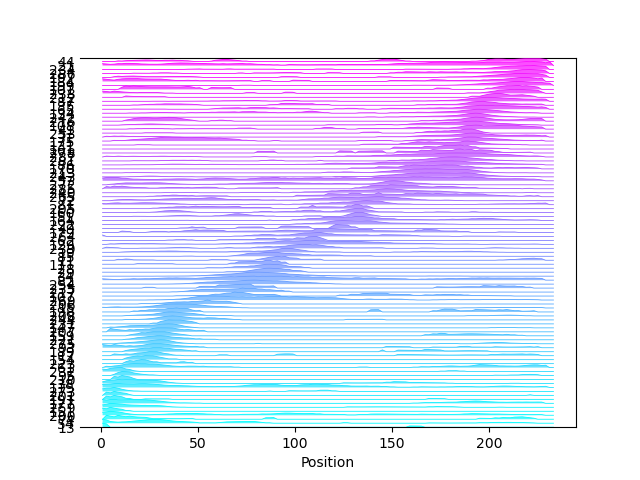

In [59]:
_, ax = plt.subplots()

plotting.plot_ratemap(pf, normalize_tuning_curve=True, ax=ax, cmap="cool")